In [1]:
# import librosa
# import IPython.display
# import matplotlib as mpl
# import matplotlib.font_manager as fm

In [2]:
# data.zip 파일 업로드

In [3]:
########################################################################
# import default python-library
########################################################################
import pickle
import os
import sys
import glob
########################################################################


########################################################################
# import additional python-library
########################################################################
import numpy as np
import librosa
import librosa.core
import librosa.display
import librosa.feature
import yaml
import logging
# from import
from tqdm import tqdm
from sklearn import metrics
from keras.models import Model
from keras.layers import Input, Dense
########################################################################

In [4]:
########################################################################
# setup STD I/O
########################################################################
"""
Standard output is logged in "autoencoder.log".
"""
logging.basicConfig(level=logging.DEBUG, filename="autoencoder.log")
logger = logging.getLogger(' ')
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
########################################################################

In [5]:
########################################################################

# wav file Input
def file_load(wav_name, mono=False):
    """
    load .wav file.

    wav_name : str
        target .wav file
    sampling_rate : int
        audio file sampling_rate
    mono : boolean
        When load a multi channels file and this param True, the returned data will be merged for mono data

    return : numpy.array( float )
    """
    try:
        return librosa.load(wav_name, sr=None, mono=mono)
    except:
        logger.error("file_broken or not exists!! : {}".format(wav_name))


def demux_wav(wav_name, channel=0):
    """
    demux .wav file.

    wav_name : str
        target .wav file
    channel : int
        target channel number

    return : numpy.array( float )
        demuxed mono data

    Enabled to read multiple sampling rates.

    Enabled even one channel.
    """
    try:
        multi_channel_data, sr = file_load(wav_name)
        if multi_channel_data.ndim <= 1:
            return sr, multi_channel_data

        return sr, np.array(multi_channel_data)[channel, :]

    except ValueError as msg:
        logger.warning(f'{msg}')


########################################################################

In [6]:
import matplotlib.pyplot as plt

# spectrograms 변환 함수 만들기
# 참고: https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html
def make_iamge(SOURCE,
               TARGET,
               n_mels=128,
               frames=5,
               n_fft=1024,
               hop_length=512,
               power=2.0):

    # 01 calculate the number of dimensions
    dims = n_mels * frames

    # 02 generate melspectrogram using librosa (**kwargs == param["librosa"])
    sr, y = demux_wav(SOURCE)

    # file = SOURCE
    # y, sr = librosa.load(file) # (default  sr=22050)
    # Return
      # y: np.ndarray [shape=(n,) or (…, n)] / audio time series. Multi-channel is supported.
      # sr: number > 0 [scalar / sampling rate of
    # S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spectrogram = librosa.feature.melspectrogram(y=y,
                                                     sr=sr,
                                                     n_fft=n_fft,
                                                     hop_length=hop_length,
                                                     n_mels=n_mels,
                                                     power=power)

    # Returns
      # S: np.ndarray [shape=(…, n_mels, t)] / Mel spectrogram
    S_dB = librosa.power_to_db(mel_spectrogram, ref=np.max)
    if TARGET == '':
      plt.figure(figsize=(12, 4))
      librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
      plt.title('mel power spectrogram')
      plt.colorbar(format='%+02.0f dB')
      plt.tight_layout()
      plt.show()
    else:
      fig = plt.figure(figsize=(15, 15))
      plt.axis('off')
      librosa.display.specshow(S_dB, sr=sr)
      plt.savefig(TARGET, bbox_inches='tight', pad_inches=0)
      plt.close(fig)  

In [7]:
import matplotlib.pyplot as plt

# spectrograms 변환 함수 만들기
# 참고: https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html
def make_iamge2(SOURCE, TARGET, FIG_SIZE):

    # 01 calculate the number of dimensions
    #dims = n_mels * frames

    # 02 generate melspectrogram using librosa (**kwargs == param["librosa"])
    sr, y = demux_wav(SOURCE)

    # STFT -> spectrogram
    hop_length = 512  # in num. of samples
    n_fft = 2048  # window in num. of samples

    # perform stft
    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)

    # calculate abs values on complex numbers to get magnitude
    spectrogram = np.abs(stft)  # np.abs(stft) ** 2

    # apply logarithm to cast amplitude to Decibels
    log_spectrogram = librosa.amplitude_to_db(spectrogram)

    if TARGET == '':
      plt.figure(figsize=(12, 4))
      librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')
      plt.title('mel power spectrogram')
      plt.colorbar(format='%+02.0f dB')
      plt.tight_layout()
      plt.show()
    else:
      fig = plt.figure(figsize=FIG_SIZE)
      plt.axis('off')
      librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
      plt.savefig(TARGET, bbox_inches='tight', pad_inches=0)
      plt.close(fig)  

In [8]:
# https://wfdb.readthedocs.io/en/latest/
# The native Python waveform-database (WFDB) package
# A library of tools for reading, writing, and processing WFDB signals and annotations.
import wfdb

In [9]:
# import PIL
# import PIL.Image
# import tensorflow as tf
# import tensorflow_datasets as tfds

# 이미지 로드 및 전처리
# 참고: https://www.tensorflow.org/tutorials/load_data/images?hl=ko
#       Tensorflow공식 튜토리얼: 이미지 로드 및 전처리하기 
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
# import tensorflow_datasets as tfds

In [10]:
print(tf.__version__)

2.8.0


In [11]:
# 데이터세트 형식으로 만들기
import pathlib

# data_dir = pathlib.Path('./content/data/out')
data_dir = pathlib.Path('./dataset/36cc_out')
print(type(data_dir))
print(data_dir)

<class 'pathlib.WindowsPath'>
dataset\36cc_out


In [12]:
# image count
# image_count = len(list(data_dir.glob('*/*.jpg')))
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

40


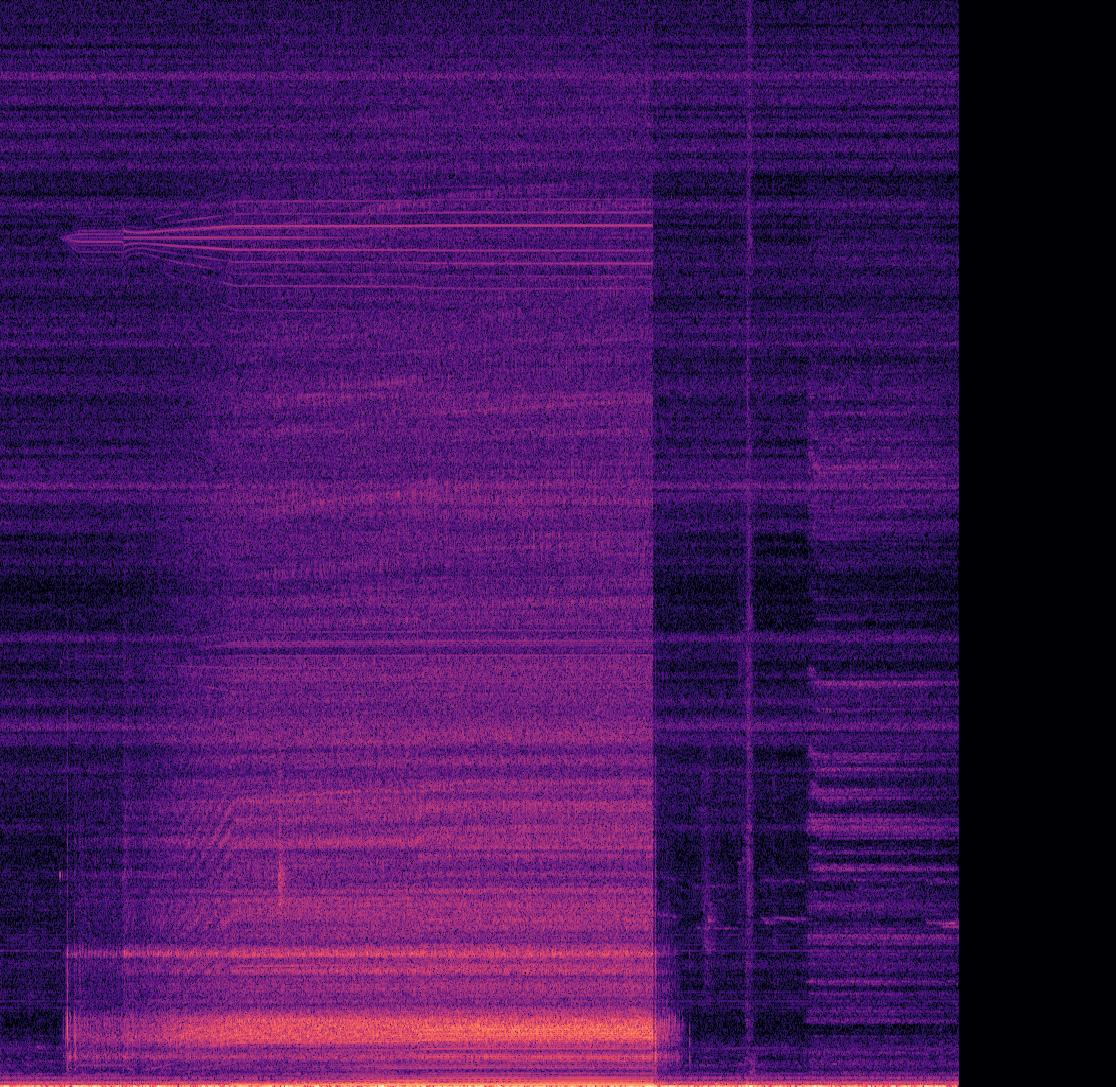

In [13]:
# image 1개 보기
# a_h = list(data_dir.glob('a_h/*'))
normal = list(data_dir.glob('normal/*'))
PIL.Image.open(str(normal[11]))

In [14]:
from tensorflow.python.keras.layers.core import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from sklearn.metrics import accuracy_score, precision_score, recall_score
import tensorflow.keras as keras
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pathlib
import librosa
import librosa.display
import concurrent.futures

In [15]:
'''
2. Load training images  
'''
# resize and normalize data for training


def create_training_data(data_path, size=224):
    training_data = []
    # for category in CATEGORIES:  # "baseline" and "rattle"

    #     path = os.path.join(data_path, category)  # create path
    #     # get the classification  (0 or a 1). 0=baseline 1=rattle
    #     class_index = CATEGORIES.index(category)

    # iterate over each image
    for image in os.listdir(data_path):
        # check file extention
        if image.endswith(".jpg"):
            try:
                data_path = pathlib.Path(data_path)
                full_name = str(pathlib.Path.joinpath(data_path, image))
                data = cv2.imread(str(full_name), 0)
                # resize to make sure data consistency
                resized_data = cv2.resize(data, (size, size))
                # add this to our training_data
                training_data.append([resized_data])
            except Exception as err:
                print("an error has occured: ", err, str(full_name))

    # normalize data
    training_data = np.array(training_data)/255.
    # reshape
    training_data = np.array(training_data).reshape(-1, size, size)
    return training_data

In [16]:
'''
3. Build autoencoder 
'''
# Define a convolutional Autoencoder


class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        # input layer
        self.latent_dim = latent_dim
        # 1st dense layer
        # self.encoder = tf.keras.Sequential([
        #     layers.Flatten(),
        #     layers.Dense(128, activation='relu'),
        #     layers.Dense(64, activation='relu'),
        #     layers.Dense(32, activation='relu'),

        # ])
        # self.decoder = tf.keras.Sequential([
        #     layers.Dense(64, activation='relu'),
        #     layers.Dense(128, activation='relu'),
        #     layers.Dense(224*224, activation='sigmoid'),
        #     layers.Reshape((224, 224))
        # ])
        # self.encoder = tf.keras.Sequential([
        #     layers.Flatten(),
        #     layers.Dense(256, activation='relu'),
        #     layers.Dense(128, activation='relu'),
        #     layers.Dense(64, activation='relu'),

        # ])
        # self.decoder = tf.keras.Sequential([
        #     layers.Dense(128, activation='relu'),
        #     layers.Dense(256, activation='relu'),
        #     layers.Dense(224*224, activation='sigmoid'),
        #     layers.Reshape((224, 224))
        # ])
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(128, activation='relu'),

        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(256, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(224*224, activation='sigmoid'),
            layers.Reshape((224, 224))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [17]:
'''
4. Set threshold
'''

def model_threshold(autoencoder, x_train):
    encoded_imgs = autoencoder.encoder(x_train).numpy()
    decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
    loss = tf.keras.losses.mse(decoded_imgs, x_train)
    each_loss= []
    for i in range(loss.shape[0]):
        each_loss.append(np.mean(loss[i]))
    #     print(i, ": ", np.mean(each_loss[i]))
    # print(np.mean(each_loss))        
    mean = np.mean(each_loss)
    std = np.std(each_loss)
    threshold = np.mean(each_loss) + np.std(each_loss)
    return each_loss, mean, std, threshold

In [18]:
'''
5. Make an inference
'''


def spectrogram_loss(autoencoder, spectrogram, size=224):
    data = np.ndarray(shape=(1, size, size), dtype=np.float32)
    # individual sample
    # Load an image from a file
    data = cv2.imread(str(spectrogram), 0)
    # resize to make sure data consistency
    resized_data = cv2.resize(data, (size, size))
    # nomalize img
    normalized_data = resized_data.astype('float32') / 255.
    # test an image
    encoded = autoencoder.encoder(normalized_data.reshape(-1, size, size))
    decoded = autoencoder.decoder(encoded)
    loss = tf.keras.losses.mse(decoded, normalized_data)
    sample_loss = np.mean(loss) + np.std(loss)
    return sample_loss

In [19]:
'''
2. Load training images
'''
data_path = "./dataset/36cc_out/normal"
x_train = create_training_data(data_path)

data_path = "./dataset/36cc_out/normal_test"
x_test_normal = create_training_data(data_path)

data_path = "./dataset/36cc_out/abnormal"
x_test_abnormal = create_training_data(data_path)

In [20]:
from sklearn.model_selection import train_test_split
X_train_split, X_test_split, __ , __ = train_test_split(x_train, x_train, test_size=0.05, random_state=42)


In [21]:
print(X_train_split.shape)
print(X_test_split.shape)

(34, 224, 224)
(2, 224, 224)


In [22]:
'''
3. Build autoencoder 
'''
autoencoder = Autoencoder(latent_dim=64*2)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

history = autoencoder.fit(X_train_split, X_train_split,
						  epochs=100,
						  #shuffle=True,
						  batch_size=16, verbose=1,
						  validation_data=(X_test_split, X_test_split))

Epoch 1/100
3/3 [==============================] - 1s 62ms/step - loss: 0.1480 - val_loss: 0.1268
Epoch 2/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0834 - val_loss: 0.0148
Epoch 3/100
3/3 [==============================] - 0s 18ms/step - loss: 0.0223 - val_loss: 0.0200
Epoch 4/100
3/3 [==============================] - 0s 19ms/step - loss: 0.0230 - val_loss: 0.0197
Epoch 5/100
3/3 [==============================] - 0s 18ms/step - loss: 0.0232 - val_loss: 0.0206
Epoch 6/100
3/3 [==============================] - 0s 18ms/step - loss: 0.0235 - val_loss: 0.0197
Epoch 7/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0229 - val_loss: 0.0191
Epoch 8/100
3/3 [==============================] - 0s 16ms/step - loss: 0.0223 - val_loss: 0.0187
Epoch 9/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0218 - val_loss: 0.0181
Epoch 10/100
3/3 [==============================] - 0s 18ms/step - loss: 0.0210 - val_loss: 0.0174
Epoch 11/100
3/3 [=

In [23]:
# a summary of architecture
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 256)               12845312  
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
Total params: 12,944,000
Trainable params: 12,944,000
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)      

In [24]:
# plot history
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
# plt.title("36cc(128*64*32*64*128)")
# plt.title("36cc(256*128*64*128*256)")
plt.title("36cc(256*256*128*256*256)")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim([0, 0.15])
plt.show()

In [25]:
print("loss: ", np.mean(history.history["loss"]))
print("val_loss: ", np.mean(history.history["val_loss"]))

loss:  0.0068419292429462075
val_loss:  0.0054904356109909715


In [26]:
# # save and load a mode
# autoencoder.save('./model_36cc/')
# autoencoder = keras.models.load_model('./model_36cc/')

In [27]:
# # load autoencoder model
# if autoencoder is None:
# 	autoencoder = Autoencoder(latent_dim=64 * 2)
# 	autoencoder = keras.models.load_model('./model_36cc/')

In [28]:
'''
4. Set threshold
'''
loss, mean, std, threshold = model_threshold(autoencoder, x_train)
# loss = tf.keras.losses.mse(decoded_imgs, x_train)
# threshold = np.mean(loss) + np.std(loss)
print("Loss: ", loss)
print("Loss mean: ", mean)
print("Loss standard deviation: ", std)
print("Threshold: ", threshold)

Loss:  [0.0012953803574101137, 0.0008788290172230678, 0.0014275945811729404, 0.0013921706011929557, 0.0018798558003879921, 0.0016274311667469686, 0.0013927511240935592, 0.000100804714900813, 0.0014436461477225766, 0.00123492905794825, 0.0010818634670967133, 0.0014811587231054984, 0.001462547508488854, 0.0013075176855415135, 0.0013874701141497324, 0.0012584660622362016, 0.0015597705342836798, 0.0011083349395012868, 0.0015639412860721578, 0.0015825963085429778, 0.0013068253918412712, 0.0015285203801846863, 0.0013868580253277312, 0.0007940679420664389, 0.0012700880686474707, 0.0016015039339812565, 0.0014414375163615833, 0.0012829908156015949, 0.0014074050872074396, 0.0013669503648277332, 0.0012367408230274045, 0.0015649864086083958, 0.0009893792755690082, 0.001278931110333389, 0.001360101424510211, 0.0021372113413244023]
Loss mean:  0.001345029364089941
Loss standard deviation:  0.0003220483257612592
Threshold:  0.0016670776898512001


In [29]:
# # load autoencoder model
# if autoencoder is None:
# 	autoencoder = keras.models.load_model('./model_36cc/')

In [30]:
# '''
# 5. Make an inference - abnormal 1
# '''
# # get statistics for each spectrogram
# # file = 'c:/data/sample/test_OK_anomal_121282111NB982000301518.jpg'
# # file = 'c:/data/sample/test_OK_121282111NB982000295218.jpg'
# file = './dataset/36cc_out/abnormal/36cc_NO_2208211119H0010019698_TDM_2022-03-30_16-22-03__Microphone.jpg'
# sample = plt.imread(file)
# plt.imshow(sample)
# sample = pathlib.Path(file)
# sample_loss = spectrogram_loss(autoencoder, sample)

In [31]:
# if sample_loss > threshold:
# 	print(
# 		f'Loss is bigger than threshold \n \
# 		  Sample Loss: {sample_loss} \n \
# 		  Threshold: {threshold} ')
# else:
# 	print(
# 		f'Loss is smaller than threshold \n \
# 		  Sample Loss: {sample_loss} \n \
# 		  Threshold: {threshold} ')

In [32]:
# '''
# 5. Make an inference - abnormal 2
# '''
# # get statistics for each spectrogram
# # file = 'c:/data/sample/test_OK_anomal_121282111NB982000301518.jpg'
# # file = 'c:/data/sample/test_OK_121282111NB982000295218.jpg'
# file = './dataset/36cc_out/abnormal/36cc_NO_2208212119H0010019788_TDM_2022-03-30_15-55-34__Microphone.jpg'
# sample = plt.imread(file)
# plt.imshow(sample)
# sample = pathlib.Path(file)
# sample_loss = spectrogram_loss(autoencoder, sample)

In [33]:
# if sample_loss > threshold:
# 	print(
# 		f'Loss is bigger than threshold \n \
# 		  Sample Loss: {sample_loss} \n \
# 		  Threshold: {threshold} ')
# else:
# 	print(
# 		f'Loss is smaller than threshold \n \
# 		  Sample Loss: {sample_loss} \n \
# 		  Threshold: {threshold} ')

In [34]:
# '''
# 5. Make an inference - normal 1
# '''
# # get statistics for each spectrogram
# # file = 'c:/data/sample/test_OK_anomal_121282111NB982000301518.jpg'
# # file = 'c:/data/sample/test_OK_121282111NB982000295218.jpg'
# file = './dataset/36cc_out/normal_test/test_36cc_OK_2208211119H0010019538_TDM_2022-03-30_15-46-18__Microphone.jpg'
# sample = plt.imread(file)
# plt.imshow(sample)
# sample = pathlib.Path(file)
# sample_loss = spectrogram_loss(autoencoder, sample)

In [35]:
# if sample_loss > threshold:
# 	print(
# 		f'Loss is bigger than threshold \n \
# 		  Sample Loss: {sample_loss} \n \
# 		  Threshold: {threshold} ')
# else:
# 	print(
# 		f'Loss is smaller than threshold \n \
# 		  Sample Loss: {sample_loss} \n \
# 		  Threshold: {threshold} ')

In [36]:
# '''
# 5. Make an inference - abnormal 2
# '''
# # get statistics for each spectrogram
# # file = 'c:/data/sample/test_OK_anomal_121282111NB982000301518.jpg'
# # file = 'c:/data/sample/test_OK_121282111NB982000295218.jpg'
# file = './dataset/36cc_out/normal_test/test_36cc_OK_2208211119H0010019618_TDM_2022-03-30_16-15-17__Microphone.jpg'
# sample = plt.imread(file)
# plt.imshow(sample)
# sample = pathlib.Path(file)
# sample_loss = spectrogram_loss(autoencoder, sample)

In [37]:
# if sample_loss > threshold:
# 	print(
# 		f'Loss is bigger than threshold \n \
# 		  Sample Loss: {sample_loss} \n \
# 		  Threshold: {threshold} ')
# else:
# 	print(
# 		f'Loss is smaller than threshold \n \
# 		  Sample Loss: {sample_loss} \n \
# 		  Threshold: {threshold} ')

In [55]:
alpha = 1
threshold = mean + alpha * std

 alpha:  1
x_train_loss:  [0.0012953803574101137, 0.0008788290172230678, 0.0014275945811729404, 0.0013921706011929557, 0.0018798558003879921, 0.0016274311667469686, 0.0013927511240935592, 0.000100804714900813, 0.0014436461477225766, 0.00123492905794825, 0.0010818634670967133, 0.0014811587231054984, 0.001462547508488854, 0.0013075176855415135, 0.0013874701141497324, 0.0012584660622362016, 0.0015597705342836798, 0.0011083349395012868, 0.0015639412860721578, 0.0015825963085429778, 0.0013068253918412712, 0.0015285203801846863, 0.0013868580253277312, 0.0007940679420664389, 0.0012700880686474707, 0.0016015039339812565, 0.0014414375163615833, 0.0012829908156015949, 0.0014074050872074396, 0.0013669503648277332, 0.0012367408230274045, 0.0015649864086083958, 0.0009893792755690082, 0.001278931110333389, 0.001360101424510211, 0.0021372113413244023]
 mean(loss):  0.001345029364089941
std(loss)*a:  0.0003220483257612592
  threshold:  0.0016670776898512001
min of x_train_loss 0.000100804714900813
max

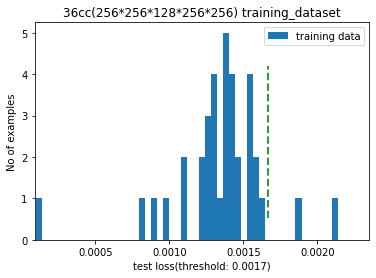

In [56]:
# 훈련 세트에서 정상 ECG에 대한 재구성 오류를 플롯합니다.(1-1)

x_train_loss, x_train_mean, x_train_std, x_train_threshold = model_threshold(autoencoder, x_train)

print(" alpha: ", alpha)
print("x_train_loss: ", x_train_loss)
print(" mean(loss): ", mean)
print("std(loss)*a: ", alpha * std)
print("  threshold: ", threshold)

print("min of x_train_loss", min(x_train_loss))
print("max of x_train_loss", max(x_train_loss))

x_min = min(x_train_loss+[threshold])-0.1*min(x_train_loss+[threshold])
x_max = 1.1*max(x_train_loss+[threshold])

# plt.title("36cc(128*64*32*64*128) training_dataset")
# plt.title("36cc(256*128*64*128*256) training_dataset")
plt.title("36cc(256*256*128*256*256) training_dataset")

plt.hist(x_train_loss, bins=50, color='C0', label='training data')
plt.xlabel(f"test loss(threshold: {threshold:.4f})")
plt.xlim(x_min, x_max)      # X축의 범위: [xmin, xmax]
plt.axvline(threshold, 0.1, 0.8, color='C2', linestyle='--', linewidth=2)
plt.legend(loc='upper right')

plt.ylabel("No of examples")
plt.show()



In [57]:
# 테스트 세트에서 정상 ECG에 대한 재구성 오류를 플롯합니다.(2-1)

ok_loss, ok__mean, ok__std, ok_threshold = model_threshold(autoencoder, x_test_normal)
nok_loss, nok__mean, nok__std, nok_threshold = model_threshold(autoencoder, x_test_abnormal)

print("alpha: ", alpha)
print(" nok_loss: ", ok_loss)
print(" nok_loss: ", nok_loss)

print("mean(loss): ", mean)
print("std(loss)*a: ", alpha * std)
print(" threshold: ", threshold)

print("min of ok_loss", min(ok_loss))
print("max of ok_loss", max(ok_loss))
print("min of nok_loss", min(ok_loss))
print("max of nok_loss", max(ok_loss))

x_min = min(ok_loss+nok_loss+[threshold])-0.1*min(ok_loss+nok_loss+[threshold])
x_max = 1.1*max(ok_loss+nok_loss+[threshold])

# plt.title("36cc(128*64*32*64*128) test_all")
# plt.title("36cc(256*128*64*128*256) test_abnormal")
plt.title("36cc(256*256*128*256*256) test_abnormal")

# plt.hist(ok_loss+nok_loss, bins=500, label='test data(abnormal)')

plt.hist(ok_loss, bins=1, color='C0', label='test data(normal)')
plt.hist(nok_loss, bins=50, color='C3', label='test data(abnormal)')

plt.xlabel(f"test loss(threshold: {threshold:.4f})")
plt.xlim(x_min, x_max)      # X축의 범위: [xmin, xmax]
plt.axvline(threshold, 0.1, 0.8, color='C2', linestyle='--', linewidth=2)
plt.legend(loc='upper right')

plt.ylabel("No of examples")
plt.show()

alpha:  1
 nok_loss:  [0.0015041597074144882, 0.0015556175908775078]
 nok_loss:  [0.0035944149736225274, 0.006169610811113732]
mean(loss):  0.001345029364089941
std(loss)*a:  0.0003220483257612592
 threshold:  0.0016670776898512001
min of ok_loss 0.0015041597074144882
max of ok_loss 0.0015556175908775078
min of nok_loss 0.0015041597074144882
max of nok_loss 0.0015556175908775078


In [58]:
# x_train: 36, x_test_normal: 2, x_test_abnormal: 2

# Label: 정상: 1, 비정상: 0
x_train_label = ['1','1','1','1','1','1','1','1','1','1'\
                ,'1','1','1','1','1','1','1','1','1','1'\
                ,'1','1','1','1','1','1','1','1','1','1'\
                ,'1','1','1','1','1','1']
x_test_normal_label = ['1','1']
x_test_abnormal_label = ['0','0']
x_train_label = np.array(x_train_label).astype(bool)
x_test_normal_label = np.array(x_test_normal_label).astype(bool)
x_test_abnormal_label = np.array(x_test_abnormal_label).astype(bool)

In [59]:
print(type(x_train), x_train.shape)
print(type(x_test_normal), x_test_normal.shape)
print(type(x_test_abnormal), x_test_abnormal.shape)
print(type(x_train_label), x_train_label.shape)
print(type(x_test_normal_label), x_test_normal_label.shape)
print(type(x_test_abnormal_label), x_test_abnormal_label.shape)

<class 'numpy.ndarray'> (36, 224, 224)
<class 'numpy.ndarray'> (2, 224, 224)
<class 'numpy.ndarray'> (2, 224, 224)
<class 'numpy.ndarray'> (36,)
<class 'numpy.ndarray'> (2,)
<class 'numpy.ndarray'> (2,)


In [60]:
# 재구성 오류가 임계값보다 큰 경우 ECG를 이상으로 분류합니다.
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mse(reconstructions, data)
  loss_all = []
  for i in range(data.shape[0]):
      loss_all.append(np.mean(loss[i]))
  return tf.math.less(loss_all, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [61]:
preds = predict(autoencoder, x_train, threshold)
print(preds)
print(x_train_label)
print_stats(preds, x_train_label)

tf.Tensor(
[ True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False], shape=(36,), dtype=bool)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
Accuracy = 0.9444444444444444
Precision = 1.0
Recall = 0.9444444444444444


In [62]:
test_all_data = np.concatenate([x_test_normal, x_test_abnormal], axis=0)
test_all_data_label = np.concatenate([x_test_normal_label, x_test_abnormal_label], axis=0)

In [63]:
preds = predict(autoencoder, test_all_data, threshold)
print(preds)
print(test_all_data_label)
print_stats(preds, test_all_data_label)

tf.Tensor([ True  True False False], shape=(4,), dtype=bool)
[ True  True False False]
Accuracy = 1.0
Precision = 1.0
Recall = 1.0


In [64]:
alpha = 3
threshold = mean + alpha * std

 alpha:  3
x_train_loss:  [0.0012953803574101137, 0.0008788290172230678, 0.0014275945811729404, 0.0013921706011929557, 0.0018798558003879921, 0.0016274311667469686, 0.0013927511240935592, 0.000100804714900813, 0.0014436461477225766, 0.00123492905794825, 0.0010818634670967133, 0.0014811587231054984, 0.001462547508488854, 0.0013075176855415135, 0.0013874701141497324, 0.0012584660622362016, 0.0015597705342836798, 0.0011083349395012868, 0.0015639412860721578, 0.0015825963085429778, 0.0013068253918412712, 0.0015285203801846863, 0.0013868580253277312, 0.0007940679420664389, 0.0012700880686474707, 0.0016015039339812565, 0.0014414375163615833, 0.0012829908156015949, 0.0014074050872074396, 0.0013669503648277332, 0.0012367408230274045, 0.0015649864086083958, 0.0009893792755690082, 0.001278931110333389, 0.001360101424510211, 0.0021372113413244023]
 mean(loss):  0.001345029364089941
std(loss)*a:  0.0009661449772837775
  threshold:  0.0023111743413737184
min of x_train_loss 0.000100804714900813
max

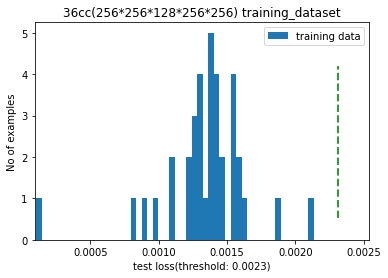

In [65]:
# 훈련 세트에서 정상 ECG에 대한 재구성 오류를 플롯합니다.(1-2)

x_train_loss, x_train_mean, x_train_std, x_train_threshold = model_threshold(autoencoder, x_train)

print(" alpha: ", alpha)
print("x_train_loss: ", x_train_loss)
print(" mean(loss): ", mean)
print("std(loss)*a: ", alpha * std)
print("  threshold: ", threshold)

print("min of x_train_loss", min(x_train_loss))
print("max of x_train_loss", max(x_train_loss))

x_min = min(x_train_loss+[threshold])-0.1*min(x_train_loss+[threshold])
x_max = 1.1*max(x_train_loss+[threshold])

# plt.title("36cc(128*64*32*64*128) training_dataset")
# plt.title("36cc(256*128*64*128*256) training_dataset")
plt.title("36cc(256*256*128*256*256) training_dataset")

plt.hist(x_train_loss, bins=50, color='C0', label='training data')
plt.xlabel(f"test loss(threshold: {threshold:.4f})")
plt.xlim(x_min, x_max)      # X축의 범위: [xmin, xmax]
plt.axvline(threshold, 0.1, 0.8, color='C2', linestyle='--', linewidth=2)
plt.legend(loc='upper right')

plt.ylabel("No of examples")
plt.show()



alpha:  3
 nok_loss:  [0.0015041597074144882, 0.0015556175908775078]
 nok_loss:  [0.0035944149736225274, 0.006169610811113732]
mean(loss):  0.001345029364089941
std(loss)*a:  0.0009661449772837775
 threshold:  0.0023111743413737184
min of ok_loss 0.0015041597074144882
max of ok_loss 0.0015556175908775078
min of nok_loss 0.0015041597074144882
max of nok_loss 0.0015556175908775078


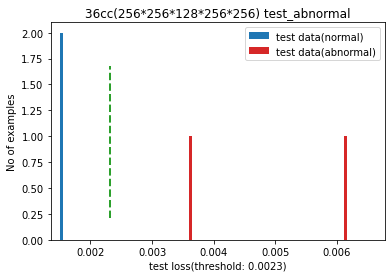

In [66]:
# 테스트 세트에서 정상 ECG에 대한 재구성 오류를 플롯합니다.(2-2)

ok_loss, ok__mean, ok__std, ok_threshold = model_threshold(autoencoder, x_test_normal)
nok_loss, nok__mean, nok__std, nok_threshold = model_threshold(autoencoder, x_test_abnormal)

print("alpha: ", alpha)
print(" nok_loss: ", ok_loss)
print(" nok_loss: ", nok_loss)

print("mean(loss): ", mean)
print("std(loss)*a: ", alpha * std)
print(" threshold: ", threshold)

print("min of ok_loss", min(ok_loss))
print("max of ok_loss", max(ok_loss))
print("min of nok_loss", min(ok_loss))
print("max of nok_loss", max(ok_loss))

x_min = min(ok_loss+nok_loss+[threshold])-0.1*min(ok_loss+nok_loss+[threshold])
x_max = 1.1*max(ok_loss+nok_loss+[threshold])

# plt.title("36cc(128*64*32*64*128) test_all")
# plt.title("36cc(256*128*64*128*256) test_abnormal")
plt.title("36cc(256*256*128*256*256) test_abnormal")

# plt.hist(ok_loss+nok_loss, bins=500, label='test data(abnormal)')

plt.hist(ok_loss, bins=1, color='C0', label='test data(normal)')
plt.hist(nok_loss, bins=50, color='C3', label='test data(abnormal)')

plt.xlabel(f"test loss(threshold: {threshold:.4f})")
plt.xlim(x_min, x_max)      # X축의 범위: [xmin, xmax]
plt.axvline(threshold, 0.1, 0.8, color='C2', linestyle='--', linewidth=2)
plt.legend(loc='upper right')

plt.ylabel("No of examples")
plt.show()

In [67]:
preds = predict(autoencoder, x_train, threshold)
print(preds)
print(x_train_label)
print_stats(preds, x_train_label)

tf.Tensor(
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True], shape=(36,), dtype=bool)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
Accuracy = 1.0
Precision = 1.0
Recall = 1.0


In [68]:
preds = predict(autoencoder, test_all_data, threshold)
print(preds)
print(test_all_data_label)
print_stats(preds, test_all_data_label)

tf.Tensor([ True  True False False], shape=(4,), dtype=bool)
[ True  True False False]
Accuracy = 1.0
Precision = 1.0
Recall = 1.0
